<a href="https://colab.research.google.com/github/IvanRobotics/AIArenaWork/blob/main/AIArena_session1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Import Libraries

In [ ]:
import matplotlib.pyplot as plt 
from sklearn.utils import resample
import seaborn as sns
import pandas as pd
import numpy as np
import json
import math
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, Dataset
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from torch.utils.data.dataset import random_split



### Load the json data and append them into corresponding list:

In [ ]:
# load the JSON file
file_path = '/content/drive/MyDrive/AI_Projects/AI Arena/training-data--session-1.json'
with open(file_path) as file:
  json_data_session1 = json.load(file)

# Extract All Features, Directions and actions
features = []
direction_action = []
other_action = []
direction_type = []
other_action_type = []

for entry in json_data_session1:
  state = entry['state'][0]
  features.append(state[:116])
  direction_type.append(entry['action']['direction'][0].index(1))
  other_action_type.append(entry['action']['other'][0])
  direction_action.append(entry['action']['direction'][0])
  other_action.append(entry['action']['other'][0])


# convert to numpy array
features = np.array(features)
direction_action = np.array(direction_action)
other_action = np.array(other_action)



In [ ]:
print(f'Unique index type:  {np.unique(direction_type)}')
print(f'Frequency of the fighter goes to the right: {direction_type.count(2)}')
print(f'Frequency of the fighter goes to the left: {direction_type.count(6)}')
print(f'Frequency of the fighter goes to the nothing: {direction_type.count(8)}')

Unique index type:  [2 6 8]
Frequency of the fighter goes to the right: 22
Frequency of the fighter goes to the left: 4
Frequency of the fighter goes to the nothing: 3


### Summary:

Direction Actions: [up (0), up-right (1), right (2), down-right (3), down (4), down-left (5), left (6), up-left (7), nothing (8)]

The unique index types of the direction are 2, 6, and 8, which correspond to the fighter's movements to the right, left, and not moving, respectively. The data shows a high frequency of the fighter consistently moving to the right, while there is a significantly lower frequency of the fighter moving to the left or not moving.



### Count the entry data

In [31]:
entry_data =  {
    'features.shape ': features.shape,
    'direction_action': direction_action.shape,
    'other_action': other_action.shape
}

row_labels = ['total entry count','total elements in an entry']

entry_df = pd.DataFrame(entry_data, index = row_labels)
entry_df

,features.shape,direction_action,other_action
total entry count,29,29,29
total elements in an entry,115,9,6


### Section each feature

In [ ]:
# check the number of unique values in each feature
Raycast_Platform_Distance = features[:,:16]
Raycast_Platform_Type = features[:,16:32]
Raycast_Projectile_Distance = features[:,32:48]
Raycast_Projectile_OnTarget =features[:,48:64]
Raycast_Projectile_Element = features[:,64:80]
Action_Representation =features[:,80:98] 
Your_Positioning = features[:,98:100]
Opponent_Positioning = features[:,100:102]
Direction = features[:,102:104]
Distance_To_Opponent = features[:,104:105]
Angle_To_Opponent= features[:,105:107]
Stocks = features[:,107:109]
Percentage = features[:,109:111]
Elemental_Gauge = features[:,111:113]
Elemental_Advantage = features[:,113:114]
Weight_Difference = features[:,114:115]
  



### Check for categorical and continuous each Feature

In [ ]:
features_list = [Raycast_Platform_Distance, Raycast_Platform_Type, Raycast_Projectile_Distance,
                 Raycast_Projectile_OnTarget, Raycast_Projectile_Element, Action_Representation,
                 Your_Positioning, Opponent_Positioning, Direction, Distance_To_Opponent,
                 Angle_To_Opponent, Stocks, Percentage, Elemental_Gauge, Elemental_Advantage,
                 Weight_Difference]


feature_names = ['Raycast_Platform_Distance', 'Raycast_Platform_Type', 'Raycast_Projectile_Distance',
                 'Raycast_Projectile_OnTarget', 'Raycast_Projectile_Element', 'Action_Representation',
                 'Your_Positioning', 'Opponent_Positioning', 'Direction', 'Distance_To_Opponent',
                 'Angle_To_Opponent', 'Stocks', 'Percentage', 'Elemental_Gauge', 'Elemental_Advantage',
                 'Weight_Difference']

for feature,feature_name in zip(features_list,feature_names):
    unique_values = np.unique(feature)
    num_unique_values = len(unique_values)
    is_categorical = num_unique_values <= 4 # Adjust the threshold as per your data

    if is_categorical:
        print(feature_name, ' is categorical')
    else:
        print(feature_name, ' is continuous')



Raycast_Platform_Distance  is continuous
Raycast_Platform_Type  is categorical
Raycast_Projectile_Distance  is categorical
Raycast_Projectile_OnTarget  is categorical
Raycast_Projectile_Element  is categorical
Action_Representation  is categorical
Your_Positioning  is continuous
Opponent_Positioning  is categorical
Direction  is categorical
Distance_To_Opponent  is continuous
Angle_To_Opponent  is continuous
Stocks  is categorical
Percentage  is categorical
Elemental_Gauge  is continuous
Elemental_Advantage  is categorical
Weight_Difference  is categorical


### Check for NaN in each Feature


In [ ]:
features_list = [Raycast_Platform_Distance, Raycast_Platform_Type, Raycast_Projectile_Distance,
                 Raycast_Projectile_OnTarget, Raycast_Projectile_Element, Action_Representation,
                 Your_Positioning, Opponent_Positioning, Direction, Distance_To_Opponent,
                 Angle_To_Opponent, Stocks, Percentage, Elemental_Gauge, Elemental_Advantage,
                 Weight_Difference]


nan_feature_list = []
for feature in features_list:
  if np.isnan(feature).any():
      nan_feature_list.append(feature)

if len(nan_feature_list) == 0:
  print('There is no NAN in session 1 dataset')
else:
  print(nan_feature_list)

There is no NAN in session 1 dataset


# Session 1: Train the fighter to get back on the stage
## Data Visualization & Data Analysis

### Plot Boxplot for each feature to find outliers


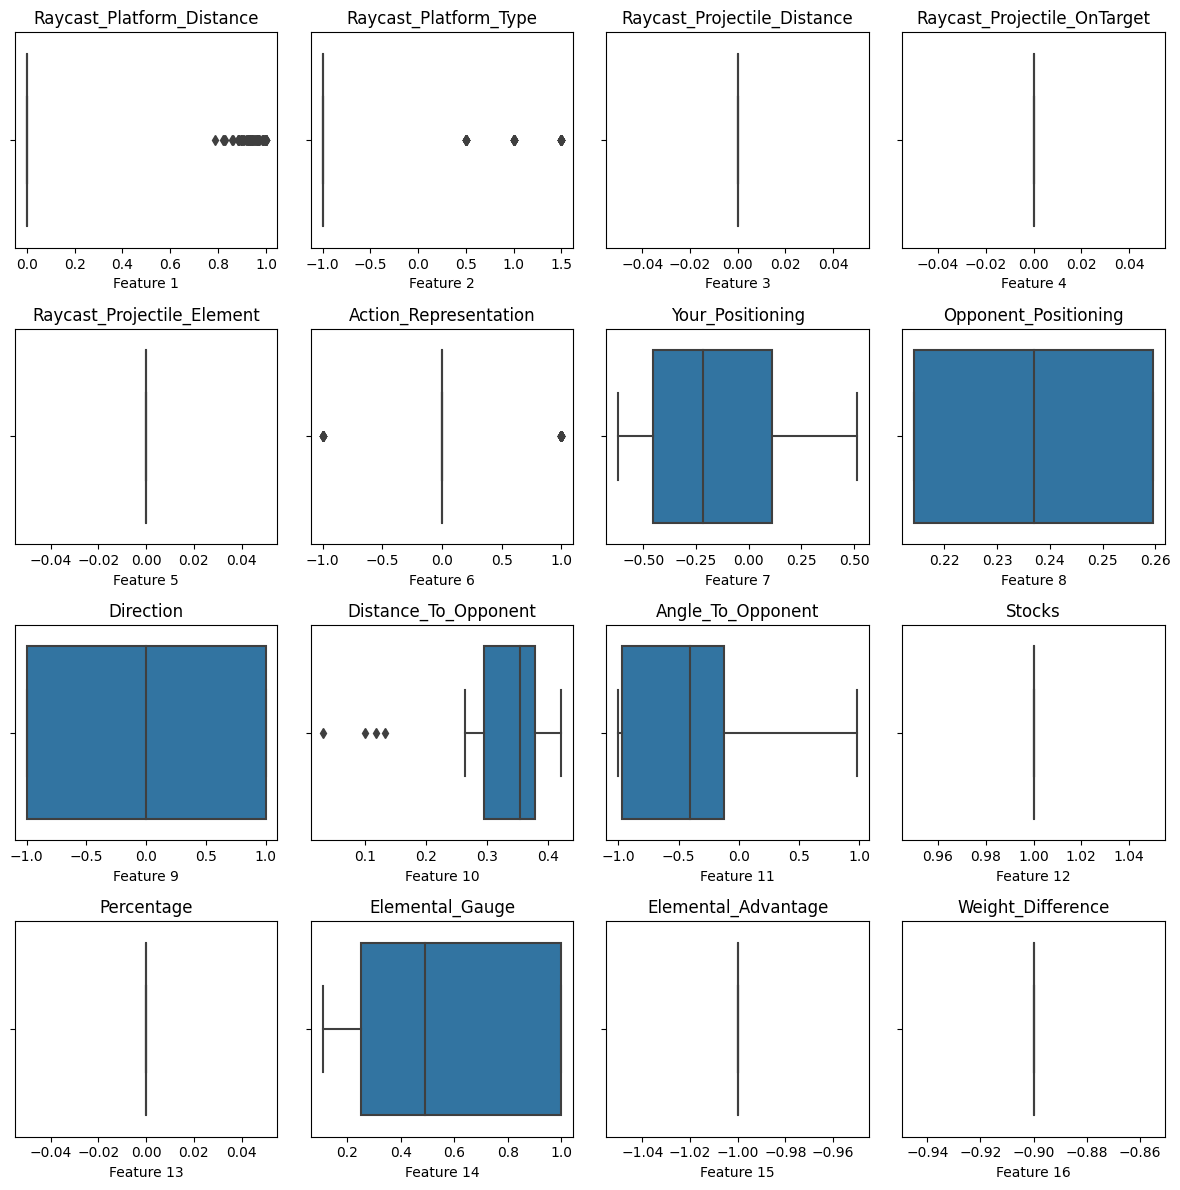

In [ ]:
features_list = [Raycast_Platform_Distance, Raycast_Platform_Type, Raycast_Projectile_Distance,
                 Raycast_Projectile_OnTarget, Raycast_Projectile_Element, Action_Representation,
                 Your_Positioning, Opponent_Positioning, Direction, Distance_To_Opponent,
                 Angle_To_Opponent, Stocks, Percentage, Elemental_Gauge, Elemental_Advantage,
                 Weight_Difference]

feature_names = ['Raycast_Platform_Distance', 'Raycast_Platform_Type', 'Raycast_Projectile_Distance',
                 'Raycast_Projectile_OnTarget', 'Raycast_Projectile_Element', 'Action_Representation',
                 'Your_Positioning', 'Opponent_Positioning', 'Direction', 'Distance_To_Opponent',
                 'Angle_To_Opponent', 'Stocks', 'Percentage', 'Elemental_Gauge', 'Elemental_Advantage',
                 'Weight_Difference']

# Preset the number of rows required
num_cols = 4
# Calculate the number of cols required
num_rows = math.ceil(len(features_list) / num_cols)

# Create subplots for each feature
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(12, 3 * num_rows))

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Plot box plots for each feature
for i, (feature, feature_name) in enumerate(zip(features_list,feature_names)):
    sns.boxplot(x=feature, ax=axes[i])
    axes[i].set_xlabel(f'Feature {i+1}')
    axes[i].set_ylabel('')
    axes[i].set_title(feature_name)

# Remove empty subplots if the number of features is not a multiple of 4
if len(features_list) % num_cols != 0:
    for j in range(len(features_list) % num_cols, num_cols):
        fig.delaxes(axes[-j-1])

plt.tight_layout()
plt.show()

As we can see that the feature 'Distance_To_Opponent' has outliners, so i will clear up the outliners in this feature later.

### Apply Random Forest to present the importance score of each feature

In [ ]:
from sklearn.ensemble import RandomForestClassifier

feature_names = [
    "Raycast_Platform_Distance",
    "Raycast_Platform_Type",
    "Raycast_Projectile_Distance",
    "Raycast_Projectile_OnTarget",
    "Raycast_Projectile_Element",
    "Action_Representation",
    "Your_Positioning",
    "Opponent_Positioning",
    "Direction",
    "Distance_To_Opponent",
    "Angle_To_Opponent",
    "Stocks",
    "Percentage",
    "Elemental_Gauge",
    "Elemental_Advantage",
    "Weight_Difference"
]

all_features = np.concatenate((
    Raycast_Platform_Distance,
    Raycast_Platform_Type,
    Raycast_Projectile_Distance,
    Raycast_Projectile_OnTarget,
    Raycast_Projectile_Element,
    Action_Representation,
    Your_Positioning,
    Opponent_Positioning,
    Direction,
    Distance_To_Opponent,
    Angle_To_Opponent,
    Stocks,
    Percentage,
    Elemental_Gauge,
    Elemental_Advantage,
    Weight_Difference
    
), axis = 1)


# y_train = np.concatenate((direction_action,other_action),axis = 1)
y_train_1 = direction_action
y_train_2 = other_action

clf1 = RandomForestClassifier(n_estimators=100, random_state=42)
clf1.fit(all_features, y_train_1)

clf2 = RandomForestClassifier(n_estimators=100, random_state=42)
clf2.fit(all_features, y_train_2)

# Get the feature importances
importances1 = clf1.feature_importances_
importances2 = clf2.feature_importances_

importance_tuples1 = list(zip(feature_names, importances1))
sorted_importances1 = sorted(importance_tuples1, key=lambda x: x[1], reverse=True)

importance_tuples2 = list(zip(feature_names, importances2))
sorted_importances2 = sorted(importance_tuples2, key=lambda x: x[1], reverse=True)


print("Importance related to direction_action")
for feature, importance in sorted_importances1:
    print(f"{feature}: {importance}")

print(" ")
print("Importance related to other_action")
for feature, importance in sorted_importances1:
    print(f"{feature}: {importance}")

Importance related to direction_action
Stocks: 0.051545459116073895
Raycast_Projectile_Element: 0.049231683680962895
Action_Representation: 0.020734144576713277
Raycast_Projectile_OnTarget: 0.013414155868144267
Raycast_Projectile_Distance: 0.004414900567626917
Your_Positioning: 0.004366534275239015
Direction: 0.0042863107048536995
Percentage: 0.0015582191780821892
Distance_To_Opponent: 0.001351981351981352
Angle_To_Opponent: 0.00040671810971080796
Opponent_Positioning: 9.730287779067975e-05
Raycast_Platform_Distance: 0.0
Raycast_Platform_Type: 0.0
Elemental_Gauge: 0.0
Elemental_Advantage: 0.0
Weight_Difference: 0.0
 
Importance related to other_action
Stocks: 0.051545459116073895
Raycast_Projectile_Element: 0.049231683680962895
Action_Representation: 0.020734144576713277
Raycast_Projectile_OnTarget: 0.013414155868144267
Raycast_Projectile_Distance: 0.004414900567626917
Your_Positioning: 0.004366534275239015
Direction: 0.0042863107048536995
Percentage: 0.0015582191780821892
Distance_To_

### Set Up Threshold to extract relevant features

In [ ]:
# Extract relevant features for direction
relevant_features = []
threshold = 0.01
for feature, importance in sorted_importances1:
  if importance > threshold:
    relevant_features.append(feature)

print('Relevant_features of direction_action are: ', relevant_features)

Relevant_features of direction_action are:  ['Stocks', 'Raycast_Projectile_Element', 'Action_Representation', 'Raycast_Projectile_OnTarget']


In [ ]:
# Extract relevant features for other action
relevant_features = []
threshold = 0.01
for feature, importance in sorted_importances2:
  if importance > threshold:
    relevant_features.append(feature)

print('Relevant_features of other_action are: ', relevant_features)

Relevant_features of other_action are:  ['Raycast_Projectile_OnTarget', 'Action_Representation', 'Raycast_Projectile_Distance', 'Stocks', 'Raycast_Projectile_Element']


### Combine relevant features for Direction and Action

1.   Raycast_Platform_Distance
2.   Raycast_Platform_Type
3.   Direction
4.   Your_Positioning
5.   Action_Representation
6.   Distance_To_Opponent
7.   Angle_To_Opponent
8.   Stocks
9.   Raycast_Projectile_Element
10.  Raycast_Projectile_OnTarget
11.  Raycast_Projectile_Distance

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2829: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2830: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


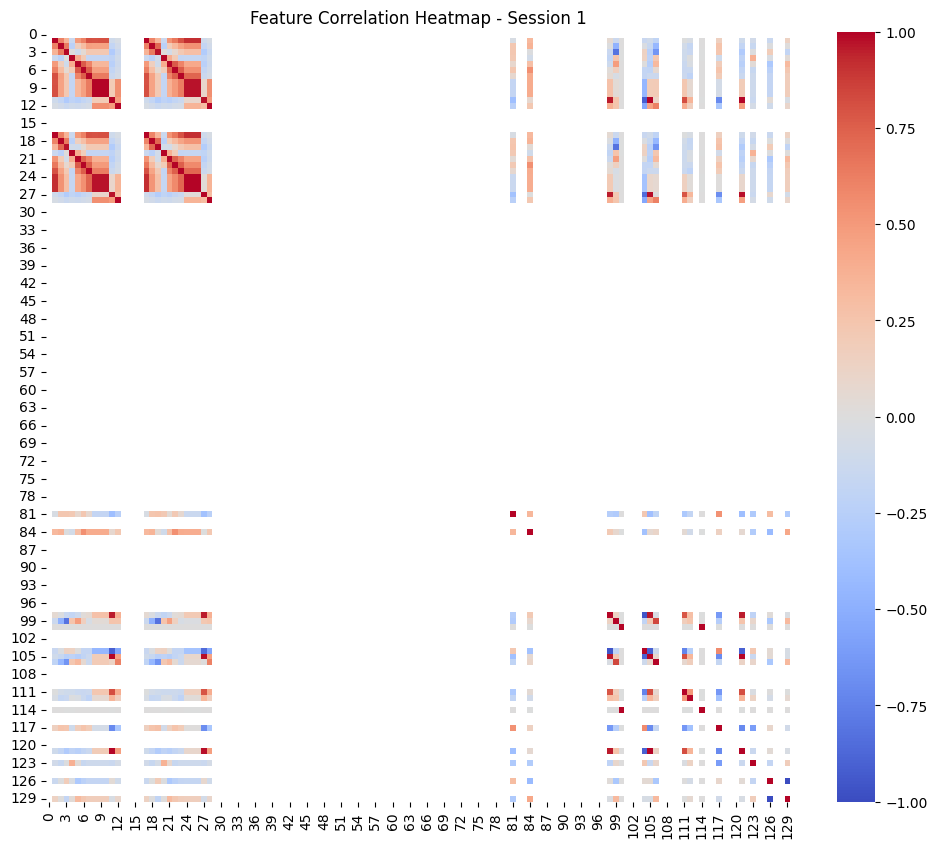

In [32]:
features = np.array(features)
direction_action = np.array(direction_action)
other_action = np.array(other_action)

all_features = np.concatenate((features, direction_action, other_action), axis=1)

corr_matrix = np.corrcoef(all_features,rowvar=False)
fig,ax = plt.subplots(figsize =(12,10))
sns.heatmap(corr_matrix, annot=False, cmap ='coolwarm',ax=ax)

# Customize the plot
plt.title('Feature Correlation Heatmap - Session 1')
plt.xticks(rotation=90)
plt.yticks(rotation=0)

# Display the plot
plt.show()

In [ ]:
print(f'Unique value of Raycast_Projectile_Element, {np.unique(Raycast_Projectile_Element)}')
print(f'Unique value of Raycast_Projectile_OnTarget, {np.unique(Raycast_Projectile_OnTarget)}')
print(f'Unique value of Stocks, {np.unique(Stocks)}')
print(f'Unique value of Raycast_Projectile_Distance, {np.unique(Raycast_Projectile_Distance)}')



Unique value of Raycast_Projectile_Element, [0.]
Unique value of Raycast_Projectile_OnTarget, [0.]
Unique value of Stocks, [1.]
Unique value of Raycast_Projectile_Distance, [0.]


From the random tree forest estimation and heatmap above, we can see that the relevant features you want to focus on would be 
    

1.   Raycast_Platform_Distance
2.   Raycast_Platform_Type
3.   Direction
4.   Your_Positioning
5.   Action_Representation
6.   Distance_To_Opponent
7.   Angle_To_Opponent
8.   Stocks
9.   Raycast_Projectile_Element
10.  Raycast_Projectile_OnTarget
11.  Raycast_Projectile_Distance

However, there are four features have only one unique value, and they are Raycast_Projectile_Element, Raycast_Projectile_OnTarget,Raycast_Projectile_Distance and Stocks. Random Forest identifies these features as relevant due to their potential impact on the model's output, assuming their values vary. In other words, the algorithm is saying that if there were non-zero values in these features, they would have a significant effect on the outcome. Thus, we will remove these four features from the relevant feature list


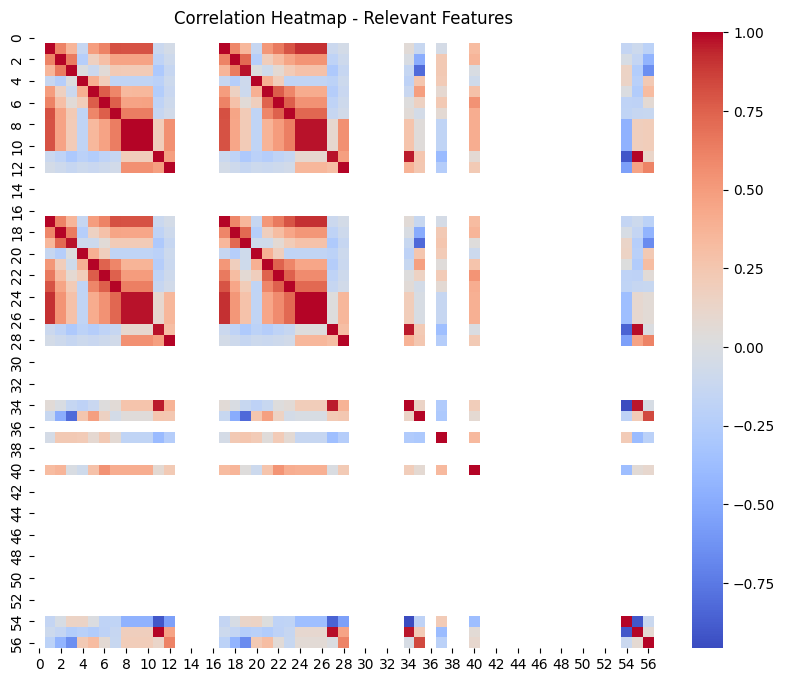

In [33]:
relevant_features = np.concatenate((
    Raycast_Platform_Distance, 
    Raycast_Platform_Type,
    Direction, 
    Your_Positioning, 
    Action_Representation, 
    Distance_To_Opponent, 
    Angle_To_Opponent,  
), axis=1)

# Compute the correlation matrix
corr_matrix = np.corrcoef(relevant_features, rowvar=False)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Heatmap - Relevant Features')
plt.show()


### Visualize Raycast Platform Distance

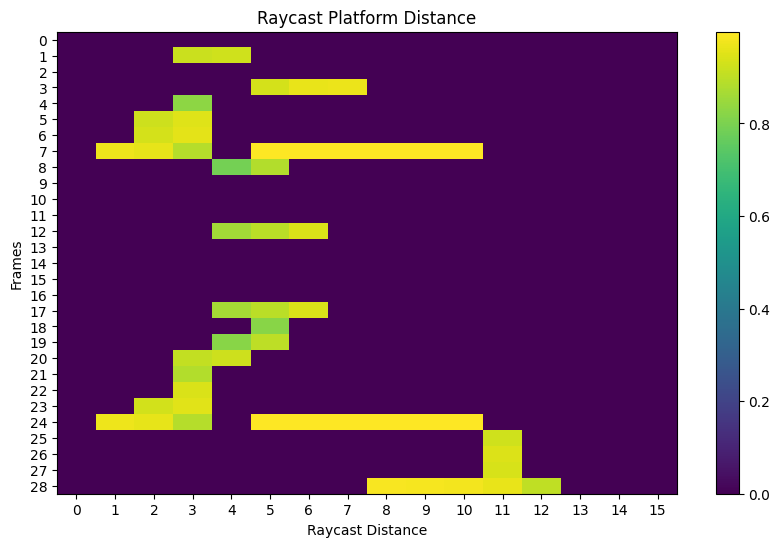

In [ ]:
# Raycast_Platform_Distance
raycast_platform_distance = features[:,:16]
# creating a fig and axis, and set the fig size
fig, ax = plt.subplots(figsize = (10,6))

#creating a heatmap
heatmap = ax.imshow(raycast_platform_distance, cmap ='viridis', aspect='auto')

#adding colorbar
cbar = plt.colorbar(heatmap)

#adding labels and title
ax.set_xticks(np.arange(0,16))
ax.set_yticks(np.arange(0,29))

ax.set_xlabel('Raycast Distance')
ax.set_ylabel('Frames')
ax.set_title('Raycast Platform Distance')

plt.show()




In [ ]:
count = 0
for i in range(29):
  unique_values = np.unique(raycast_platform_distance[i,:])
  if (unique_values == 0.).all():
    count += 1

print(f'There are {count} frames that have no ray intersecting with the fighter')

There are 9 frames that have no ray intersecting with the fighter


### Visualize raycast_platform_distance

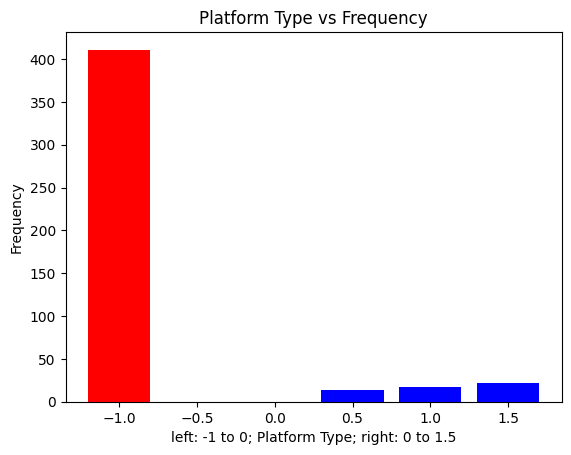

In [ ]:
# raycast_platform_type
raycast_platform_type = features[:, 16:32]
platform_type = [-1, 0.5, 1, 1.5] # Hard Platform and Wall: 1,  Soft Platform: 0.5, Ledge: 1.5
platform_type_count = [np.sum(raycast_platform_type == t) for t in platform_type]


bar_color = ['red' if t<0 else 'blue' for t in platform_type]
bar_width = 0.4
plt.bar(platform_type, platform_type_count, color = bar_color, width = bar_width)
plt.xlabel('left: -1 to 0; Platform Type; right: 0 to 1.5')
plt.ylabel('Frequency')
plt.title('Platform Type vs Frequency')
plt.show()

From the barplot above, we can see that the majority frequency happens at the value of "-1", which indicates that the fighter might be off the stage or far from any platforms like soft, hard or ledge. 

### Visualize Position Type


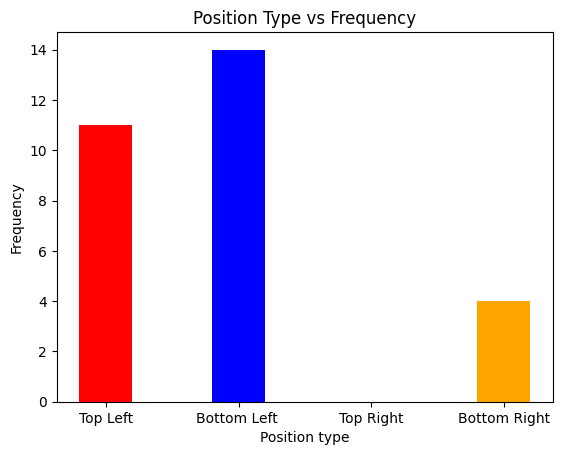

In [ ]:
position_type = [-1,1]
Your_Positioning  =  features[:,98:100]
left_top = np.sum((Your_Positioning[:, 0] < 0) & (Your_Positioning[:, 1] < 0))
left_bottom = np.sum((Your_Positioning[:, 0] < 0) & (Your_Positioning[:, 1] > 0))
right_top = np.sum((Your_Positioning[:, 0] > 0) & (Your_Positioning[:, 1] < 0))
right_bottom = np.sum((Your_Positioning[:, 0] > 0) & (Your_Positioning[:, 1] > 0))

categories = ['Top Left', 'Bottom Left ', 'Top Right', 'Bottom Right']
bar_colors = ['red', 'blue', 'green', 'orange']
bar_width = 0.4
plt.bar(categories, [left_top, left_bottom, right_top, right_bottom], color = bar_colors, width = bar_width)
plt.xlabel('Position type')
plt.ylabel('Frequency')
plt.title('Position Type vs Frequency')
plt.show()



Based on the plot above, we can observe that the majority of the data points are concentrated in the top-left and bottom-left positions. There are relatively few data points collected at the bottom-right position, and an insignificant amount of data collected at the top-right position. Thus, we run into an issue of data imbalance. To address this issue, we can generate synethic data for the right hand side by using methods below.

# Data Preprocessing

##### Step 1: Boostrap data size of some important features such as raycast_platform_type, etc

In [ ]:
# def bootstrap_features(relevant_features_dict, num_sample, direction_action, other_action):
#     direct_action = np.array(direction_action)
#     other_act = np.array(other_action)
#     bootstrapped_feature = {}
#     relevant_features_augmented = {}

#     Your_Positioning = relevant_features_dict['Your_Positioning']
#     indices_left_top = np.where((Your_Positioning[:, 0] < 0) & (Your_Positioning[:, 1] < 0))
#     indices_left_bottom = np.where((Your_Positioning[:, 0] < 0) & (Your_Positioning[:, 1] > 0))
#     indices_right_top = np.where((Your_Positioning[:, 0] > 0) & (Your_Positioning[:, 1] < 0))
#     indices_right_bottom = np.where((Your_Positioning[:, 0] > 0) & (Your_Positioning[:, 1] > 0))

#     direction_actions_right_bottom = direct_action[indices_right_bottom]
#     other_action_right_bottom = other_act[indices_right_bottom]

#     for feature_name, relevant_fea in relevant_features_dict.items():
#         subset_right_bottom = relevant_fea[indices_right_bottom]
        
#         # Bootstrap the subset
#         bootstrapped_feature[feature_name] = resample(subset_right_bottom, replace=True, n_samples=num_sample)
#         relevant_features_augmented[feature_name] = np.concatenate([relevant_fea, bootstrapped_feature[feature_name]])

#     # Bootstrap the actions
#     bootstrapped_actions = resample(other_action_right_bottom, replace=True, n_samples=num_sample)
#     bootstrapped_directions = resample(direction_actions_right_bottom, replace=True, n_samples=num_sample)

#     # Combine the bootstrapped actions with the original actions
#     other_actions_augmented = np.concatenate([other_act, bootstrapped_actions])
#     direction_actions_augmented = np.concatenate([direct_action, bootstrapped_directions])

#     return relevant_features_augmented, other_actions_augmented, direction_actions_augmented


In [ ]:
def bootstrap_features(relevant_features_dict, num_sample, direction_action, other_action):
    direct_action = np.array(direction_action)
    other_act = np.array(other_action)
    bootstrapped_feature = {}
    relevant_features_augmented = {}

    Your_Positioning = relevant_features_dict['Your_Positioning']
    indices_left_top = np.where((Your_Positioning[:, 0] < 0) & (Your_Positioning[:, 1] < 0))
    indices_left_bottom = np.where((Your_Positioning[:, 0] < 0) & (Your_Positioning[:, 1] > 0))
    indices_right_top = np.where((Your_Positioning[:, 0] > 0) & (Your_Positioning[:, 1] < 0))
    indices_right_bottom = np.where((Your_Positioning[:, 0] > 0) & (Your_Positioning[:, 1] > 0))

    indices_majority = [indices_left_top, indices_left_bottom]
    indices_minority = indices_right_bottom

    direction_actions_minority = direct_action[indices_minority]
    other_action_minority = other_act[indices_minority]

    # Undersample the majority classes
    for feature_name, relevant_fea in relevant_features_dict.items():
        bootstrapped_feature[feature_name] = np.concatenate([relevant_fea[ind] for ind in indices_majority], axis=0)
        bootstrapped_feature[feature_name] = resample(bootstrapped_feature[feature_name], replace=False, n_samples=num_sample, random_state=0)
        relevant_features_augmented[feature_name] = np.concatenate([relevant_fea, bootstrapped_feature[feature_name]])

    # Oversample the minority class
    for feature_name, relevant_fea in relevant_features_dict.items():
        subset_minority = relevant_fea[indices_minority]
        bootstrapped_feature[feature_name] = resample(subset_minority, replace=True, n_samples=num_sample)
        relevant_features_augmented[feature_name] = np.concatenate([relevant_fea, bootstrapped_feature[feature_name]])

    # Bootstrap the actions
    bootstrapped_actions = resample(other_action_minority, replace=True, n_samples=num_sample)
    bootstrapped_directions = resample(direction_actions_minority, replace=True, n_samples=num_sample)

    # Combine the bootstrapped actions with the original actions
    other_actions_augmented = np.concatenate([other_act, bootstrapped_actions])
    direction_actions_augmented = np.concatenate([direct_action, bootstrapped_directions])

    return relevant_features_augmented, other_actions_augmented, direction_actions_augmented


### Perform Bootstrapping on all relevant features along with Direction and Action

In [ ]:
import random

relevant_features_dict = {
    "Raycast_Platform_Distance": Raycast_Platform_Distance,
    "Raycast_Platform_Type": Raycast_Platform_Type,
    "Direction": Direction,
    "Your_Positioning": Your_Positioning,
    "Action_Representation": Action_Representation,
    "Distance_To_Opponent": Distance_To_Opponent,
    "Angle_To_Opponent": Angle_To_Opponent,

}

num_sample = 10
augmented_rel_features, augmented_other_action, augmented_directions = bootstrap_features(relevant_features_dict, num_sample, direction_action, other_action)
Your_Positioning_augmented = augmented_rel_features['Your_Positioning']




### Visualize the position type

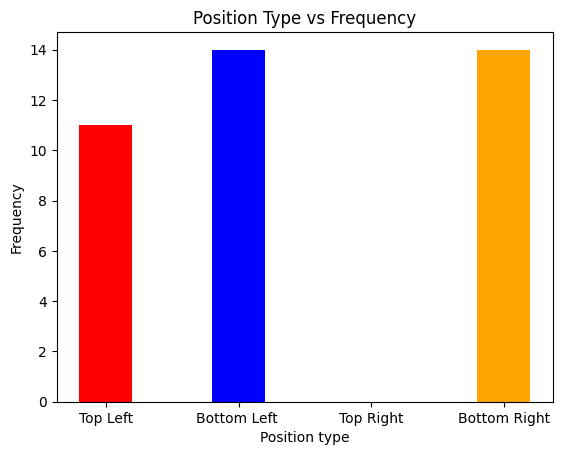

In [ ]:
position_type = [-1,1]
left_top = np.sum((Your_Positioning_augmented[:, 0] < 0) & (Your_Positioning_augmented[:, 1] < 0))
left_bottom = np.sum((Your_Positioning_augmented[:, 0] < 0) & (Your_Positioning_augmented[:, 1] > 0))
right_top = np.sum((Your_Positioning_augmented[:, 0] > 0) & (Your_Positioning_augmented[:, 1] < 0))
right_bottom = np.sum((Your_Positioning_augmented[:, 0] > 0) & (Your_Positioning_augmented[:, 1] > 0))

categories = ['Top Left', 'Bottom Left ', 'Top Right', 'Bottom Right']
bar_colors = ['red', 'blue', 'green', 'orange']
bar_width = 0.4
plt.bar(categories, [left_top, left_bottom, right_top, right_bottom], color = bar_colors, width = bar_width)
plt.xlabel('Position type')
plt.ylabel('Frequency')
plt.title('Position Type vs Frequency')
plt.show()



From the barplot above, we can see that after bootstrapping, the data size expanded at the Bottom Right position

In [ ]:
#initialize concat dataframe
concat_input_df = pd.DataFrame()
print(f'The length of augmented_rel_features should be {len(augmented_rel_features)}' )

for feature_name, feature_type in augmented_rel_features.items():
    input_df = pd.DataFrame(feature_type, columns=[f'feature{i+1}' for i in range(feature_type.shape[1])])
    concat_input_df = pd.concat([concat_input_df, input_df], axis = 1)

concat_input_df.head(10)

The length of augmented_rel_features should be 7


,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,...,feature12,feature13,feature14,feature15,feature16,feature17,feature18,feature1,feature1,feature2
0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.388070,-0.988127,-0.153640
1,0.0,0.000000,0.000000,0.916612,0.927959,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.363666,-0.965025,-0.262156
2,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.347361,-0.973696,-0.227852
3,0.0,0.000000,0.000000,0.000000,0.000000,0.934988,0.964816,0.968972,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.272081,-0.993699,-0.112084
4,0.0,0.000000,0.000000,0.826934,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.354761,-0.916960,-0.398980
5,0.0,0.000000,0.923750,0.948037,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.351934,-0.903989,-0.427555
6,0.0,0.000000,0.933367,0.958747,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.333717,-0.915473,-0.402379
7,0.0,0.971118,0.962264,0.888243,0.000000,0.995498,0.997563,0.998135,0.998277,0.998135,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.263731,-0.945821,-0.324687
8,0.0,0.000000,0.000000,0.000000,0.788842,0.884369,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.394271,-0.999214,0.039630
9,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.397575,-0.994467,-0.105051


### Create MyDataset Class


*   create a dataset that can be used with Pytorch "DataLoader" for loading and batching data
*   label input data, direction data, and other_action data
*   LongTensor is used for target labels in classification problems 

In [ ]:
class MyDataset(Dataset):
    def __init__(self, input_data, target_direction, target_other_action):
        self.input_data = torch.Tensor(input_data)
        self.target_direction = torch.LongTensor(target_direction)
        self.target_other_action = torch.LongTensor(target_other_action)

    def __len__(self):
        return len(self.input_data)

    def __getitem__(self, idx):
        return (
            self.input_data[idx],
            self.target_direction[idx],
            self.target_other_action[idx]
        )




### Build the two-headed neural network model

In [ ]:
class TwoHeadedModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size_direction, output_size_other):
        super(TwoHeadedModel, self).__init__()
        
        # Define the share layers, these layers will process the input data
        # and produce a set of shared features that will be further processed by each of the two head
        self.shared_layers = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.LeakyReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.LeakyReLU()
        )
        
        # Define first head
        # This head will process the shared features and produce the output for the direction prediction task
        self.head_direction = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.LeakyReLU(),
            nn.Linear(hidden_size, output_size_direction)
        )
        
        # Define second head
        # This head will process the shared features and produce the output for the other action prediction
        self.head_other = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.LeakyReLU(),
            nn.Linear(hidden_size, output_size_other)
        )

    #Define the forward pass of the network
    def forward(self, x):
        shared_features = self.shared_layers(x)
        direction_output = self.head_direction(shared_features)
        other_output = self.head_other(shared_features)
        return direction_output, other_output






In [ ]:
input_data = concat_input_df.values
target_direction = augmented_directions
target_other_action = augmented_other_action
target_direction.shape
# target_direction.argmax(dim=1)

input_data.shape

(39, 57)

### Train the model 



*   **Setting up the Model and Parameters**: hidden size, input size, output size, batch size, etc
*   **Cross Validation**: The code uses k-fold cross validation for model evaluation. 
*   **Loading data**: In each iteration of the CV, the data is split into train and test sets.
        *   MyDataset instances created for train and test seets
        *   Then pass them into DataLoader instsncaes for batching and shuffling 
*   **Optimizer and Loss Function**: The Cross-entropy loss function and Adam Optimizer are defined. Only the parameters of the new layers are passed to the optimizer, meaning only these parameters will be updated during training.
*   **Training Loop**: In each epoch, it iterates through the training set, calculates the loss, and updates the weights of the new layers. 

In [ ]:
input_data = concat_input_df.values
target_direction = augmented_directions
target_other_action = augmented_other_action


# Specify the number of folds
num_folds = 10

# Create an instance of StratifiedKFold
kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Rest of the code for model training and evaluation goes inside this loop
for fold, (train_index, test_index) in enumerate(kfold.split(input_data, target_direction.argmax(1))):
    # Split the data into train and test sets for the current fold
    input_train, input_test = input_data[train_index], input_data[test_index]
    target_direction_train, target_direction_test = target_direction[train_index], target_direction[test_index]
    target_other_action_train, target_other_action_test = target_other_action[train_index], target_other_action[test_index]

    # Create MyDataset instances for train and test sets
    train_dataset = MyDataset(input_train, target_direction_train, target_other_action_train)
    test_dataset = MyDataset(input_test, target_direction_test, target_other_action_test)

    train_data_session1 = train_dataset
    test_data_session1 = test_dataset

    # Define the dimensions of the model
    input_size = 57  # 
    hidden_size = 36  # 
    output_size_direction = 9  # [up (0), up-right (1), right (2), down-right (3), down (4), down-left (5), left (6), up-left (7), nothing (8)]
    output_size_other = 6  # [grab (0), shield (1), jump (2), attack (3), special (4), nothing (5)]

    # Set up the training parameters
    batch_size = 8
    learning_rate = 0.01
    num_epochs = 20

    # create dataloader for train and test sets
    train_loader = DataLoader(train_data_session1, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_data_session1, batch_size=batch_size, shuffle=False)

    # Initialize the model
    model = TwoHeadedModel(input_size, hidden_size, output_size_direction, output_size_other)

    # Define the loss functions
    criterion_direction = nn.CrossEntropyLoss()
    criterion_other = nn.CrossEntropyLoss()

    # Define the optimizer
    weight_decay = 0.01
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Train the model on session 1 data
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, targets_direction, targets_other in train_loader:
            optimizer.zero_grad()
            outputs_direction, outputs_other = model(inputs)
          
            
             # Convert target_directions and targets_other to class indices
            targets_direction_indices = targets_direction.argmax(1)
            targets_other_indices = targets_other.argmax(1)

            # Compute the losses
            loss_direction = criterion_direction(outputs_direction, targets_direction_indices)
            loss_other = criterion_other(outputs_other, targets_other_indices)

            loss = loss_direction + loss_other
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_data_session1)
        print(f"Fold {fold+1} - Epoch {epoch+1}/{num_epochs} | Training Loss: {epoch_loss:.4f}")



/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(


Fold 1 - Epoch 1/20 | Training Loss: 3.4891
Fold 1 - Epoch 2/20 | Training Loss: 1.8964
Fold 1 - Epoch 3/20 | Training Loss: 1.6640
Fold 1 - Epoch 4/20 | Training Loss: 1.3540
Fold 1 - Epoch 5/20 | Training Loss: 1.0805
Fold 1 - Epoch 6/20 | Training Loss: 0.8656
Fold 1 - Epoch 7/20 | Training Loss: 0.8417
Fold 1 - Epoch 8/20 | Training Loss: 0.7886
Fold 1 - Epoch 9/20 | Training Loss: 0.7625
Fold 1 - Epoch 10/20 | Training Loss: 0.7886
Fold 1 - Epoch 11/20 | Training Loss: 0.7722
Fold 1 - Epoch 12/20 | Training Loss: 0.7060
Fold 1 - Epoch 13/20 | Training Loss: 0.7482
Fold 1 - Epoch 14/20 | Training Loss: 0.7099
Fold 1 - Epoch 15/20 | Training Loss: 0.7407
Fold 1 - Epoch 16/20 | Training Loss: 0.7285
Fold 1 - Epoch 17/20 | Training Loss: 0.7101
Fold 1 - Epoch 18/20 | Training Loss: 0.6932
Fold 1 - Epoch 19/20 | Training Loss: 0.6890
Fold 1 - Epoch 20/20 | Training Loss: 0.6807
Fold 2 - Epoch 1/20 | Training Loss: 3.7509
Fold 2 - Epoch 2/20 | Training Loss: 2.1783
Fold 2 - Epoch 3/20 |

# Evaluation the model accuracy

In [ ]:
import torch
from sklearn.metrics import classification_report, confusion_matrix, f1_score

model.eval()
total_correct_direction = 0
total_correct_other_action = 0
total_samples = 0
predicted_directions = []
predicted_others = []
targets_directions = []
targets_others = []

with torch.no_grad():
    for inputs, targets_direction, targets_other in test_loader:
        outputs_direction, outputs_other = model(inputs)
        
        _, predicted_direction = torch.max(outputs_direction, 1)
        _, predicted_other = torch.max(outputs_other, 1)

        total_correct_direction += (predicted_direction == targets_direction.argmax(dim=1)).sum().item()
        total_correct_other_action += (predicted_other == targets_other.argmax(dim=1)).sum().item()
        
        total_samples += inputs.size(0)
        
        # Collect predictions and targets for later evaluation
        predicted_directions.extend(predicted_direction.cpu().numpy())
        predicted_others.extend(predicted_other.cpu().numpy())
        targets_directions.extend(targets_direction.argmax(dim=1).cpu().numpy())
        targets_others.extend(targets_other.argmax(dim=1).cpu().numpy())

accuracy_direction = total_correct_direction / total_samples * 100
print(f"Accuracy on Session 1 (Directin) Testing Data: {accuracy_direction:.4f}%")


accuracy_direction_other_action = total_correct_other_action / total_samples * 100
print(f"Accuracy on Session 1 (Other Action) Testing Data: {accuracy_direction_other_action:.4f}%")


# Convert the lists to numpy arrays
predicted_directions = np.array(predicted_directions)
predicted_others = np.array(predicted_others)
targets_directions = np.array(targets_directions)
targets_others = np.array(targets_others)

# Calculate F1 score
f1_direction = f1_score(targets_directions, predicted_directions, average='weighted')
f1_other = f1_score(targets_others, predicted_others, average='weighted')
print(f"F1 Score (Direction): {f1_direction:.4f}")
print(f"F1 Score (Other): {f1_other:.4f}")

# Calculate confusion matrix
confusion_matrix_direction = confusion_matrix(targets_directions, predicted_directions)
confusion_matrix_other = confusion_matrix(targets_others, predicted_others)
print("Confusion Matrix (Direction):")
print(confusion_matrix_direction)
print("Confusion Matrix (Other):")
print(confusion_matrix_other)

# Calculate classification report
classification_report_direction = classification_report(targets_directions, predicted_directions)
classification_report_other = classification_report(targets_others, predicted_others)
print("Classification Report (Direction):")
print(classification_report_direction)
print("Classification Report (Other):")
print(classification_report_other)


Accuracy on Session 1 (Directin) Testing Data: 100.0000%
Accuracy on Session 1 (Other Action) Testing Data: 100.0000%
F1 Score (Direction): 1.0000
F1 Score (Other): 1.0000
Confusion Matrix (Direction):
[[2 0]
 [0 1]]
Confusion Matrix (Other):
[[3]]
Classification Report (Direction):
              precision    recall  f1-score   support

           2       1.00      1.00      1.00         2
           6       1.00      1.00      1.00         1

    accuracy                           1.00         3
   macro avg       1.00      1.00      1.00         3
weighted avg       1.00      1.00      1.00         3

Classification Report (Other):
              precision    recall  f1-score   support

           5       1.00      1.00      1.00         3

    accuracy                           1.00         3
   macro avg       1.00      1.00      1.00         3
weighted avg       1.00      1.00      1.00         3



# Save the model

In [ ]:
torch.save(model.state_dict(),'session1_trained_model.pt')